# Завдання 1. Оптимізація доступу до даних за допомогою LRU-кешу

In [19]:
import random
import time
from collections import OrderedDict


In [20]:
class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity

    def get(self, key):
        if key in self.cache:
            self.cache.move_to_end(key)  # оновлюємо останній доступ
            return self.cache[key]
        return -1

    def put(self, key, value):
        if key in self.cache:
            self.cache.move_to_end(key)
        self.cache[key] = value
        if len(self.cache) > self.capacity:
            self.cache.popitem(last=False)  # видаляємо найстаріше


In [21]:
def range_sum_no_cache(array, left, right):
    return sum(array[left:right + 1])

def update_no_cache(array, index, value):
    array[index] = value

def range_sum_with_cache(array, left, right, cache: LRUCache):
    key = (left, right)
    cached = cache.get(key)
    if cached != -1:
        return cached
    result = sum(array[left:right + 1])
    cache.put(key, result)
    return result

def update_with_cache(array, index, value, cache: LRUCache):
    array[index] = value
    # інвалідуємо усі діапазони, які включають index
    keys_to_invalidate = [key for key in cache.cache if key[0] <= index <= key[1]]
    for key in keys_to_invalidate:
        del cache.cache[key]


In [22]:
def make_queries(n, q, hot_pool=30, p_hot=0.95, p_update=0.03):
    hot = [(random.randint(0, n//2), random.randint(n//2, n-1)) for _ in range(hot_pool)]
    queries = []

    for _ in range(q):
        if random.random() < p_update:
            idx = random.randint(0, n-1)
            val = random.randint(1, 100)
            queries.append(("Update", idx, val))
        else:
            if random.random() < p_hot:
                left, right = random.choice(hot)
            else:
                left = random.randint(0, n-1)
                right = random.randint(left, n-1)
            queries.append(("Range", left, right))
    return queries


In [23]:
n = 100_000
q = 50_000
array = [random.randint(1, 100) for _ in range(n)]
queries = make_queries(n, q)


array_copy = array[:]

start = time.time()
for query in queries:
    if query[0] == "Range":
        range_sum_no_cache(array, query[1], query[2])
    else:
        update_no_cache(array, query[1], query[2])
time_no_cache = time.time() - start


In [24]:
cache = LRUCache(capacity=1000)

start = time.time()
for query in queries:
    if query[0] == "Range":
        range_sum_with_cache(array_copy, query[1], query[2], cache)
    else:
        update_with_cache(array_copy, query[1], query[2], cache)
time_with_cache = time.time() - start


In [25]:
print(f"Без кешу :  {time_no_cache:.2f} c")
print(f"LRU-кеш  :  {time_with_cache:.2f} c  (прискорення ×{(time_no_cache / time_with_cache):.2f})")


Без кешу :  21.59 c
LRU-кеш  :  6.95 c  (прискорення ×3.11)


# Завдання 2. Порівняння продуктивності обчислення чисел Фібоначчі із використанням LRU-кешу та Splay Tree

In [26]:
import timeit
import matplotlib.pyplot as plt
from functools import lru_cache
import pandas as pd


In [27]:
@lru_cache(maxsize=None)
def fibonacci_lru(n):
    if n <= 1:
        return n
    return fibonacci_lru(n - 1) + fibonacci_lru(n - 2)


In [28]:
class SplayNode:
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.left = None
        self.right = None

class SplayTree:
    def __init__(self):
        self.root = None

    def _splay(self, root, key):
        if root is None or root.key == key:
            return root

        # Zig-Zig (Left Left)
        if key < root.key and root.left:
            if key < root.left.key:
                root.left.left = self._splay(root.left.left, key)
                root = self._rotate_right(root)
            elif key > root.left.key:
                root.left.right = self._splay(root.left.right, key)
                if root.left.right:
                    root.left = self._rotate_left(root.left)
            return self._rotate_right(root) if root.left else root

        # Zig-Zig (Right Right)
        if key > root.key and root.right:
            if key > root.right.key:
                root.right.right = self._splay(root.right.right, key)
                root = self._rotate_left(root)
            elif key < root.right.key:
                root.right.left = self._splay(root.right.left, key)
                if root.right.left:
                    root.right = self._rotate_right(root.right)
            return self._rotate_left(root) if root.right else root

        return root

    def _rotate_right(self, node):
        left = node.left
        node.left = left.right
        left.right = node
        return left

    def _rotate_left(self, node):
        right = node.right
        node.right = right.left
        right.left = node
        return right

    def search(self, key):
        self.root = self._splay(self.root, key)
        if self.root and self.root.key == key:
            return self.root.value
        return None

    def insert(self, key, value):
        if self.root is None:
            self.root = SplayNode(key, value)
            return

        self.root = self._splay(self.root, key)

        if self.root.key == key:
            self.root.value = value  # overwrite
            return

        node = SplayNode(key, value)
        if key < self.root.key:
            node.left = self.root.left
            node.right = self.root
            self.root.left = None
        else:
            node.right = self.root.right
            node.left = self.root
            self.root.right = None

        self.root = node


In [29]:
def fibonacci_splay(n, tree):
    cached = tree.search(n)
    if cached is not None:
        return cached

    if n <= 1:
        tree.insert(n, n)
        return n

    val = fibonacci_splay(n - 1, tree) + fibonacci_splay(n - 2, tree)
    tree.insert(n, val)
    return val


In [30]:
fibo_inputs = list(range(0, 951, 50))
lru_times = []
splay_times = []

for n in fibo_inputs:
    # LRU
    lru_time = timeit.timeit(lambda: fibonacci_lru(n), number=1)
    lru_times.append(lru_time)

    # Splay Tree (нове дерево для кожного n)
    tree = SplayTree()
    splay_time = timeit.timeit(lambda: fibonacci_splay(n, tree), number=1)
    splay_times.append(splay_time)


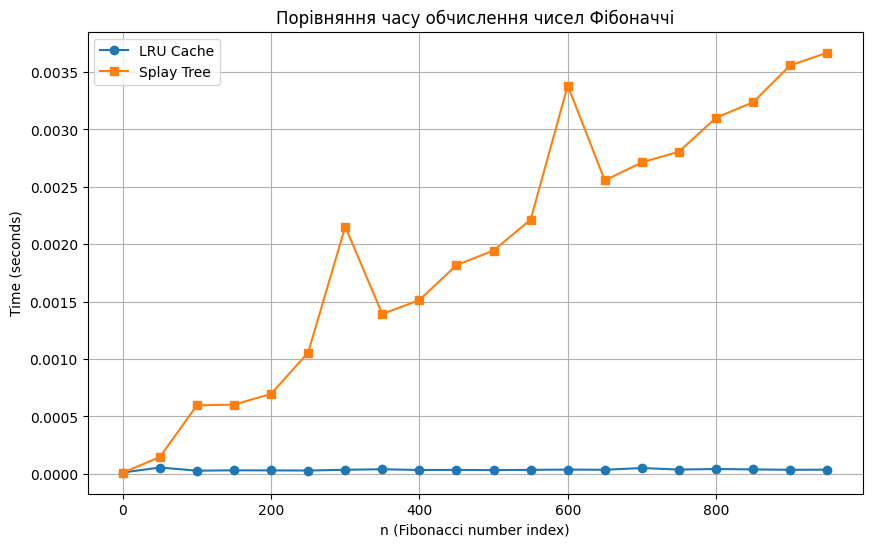

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(fibo_inputs, lru_times, label="LRU Cache", marker="o")
plt.plot(fibo_inputs, splay_times, label="Splay Tree", marker="s")
plt.xlabel("n (Fibonacci number index)")
plt.ylabel("Time (seconds)")
plt.title("Порівняння часу обчислення чисел Фібоначчі")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
df = pd.DataFrame({
    "n": fibo_inputs,
    "LRU Cache (sec)": lru_times,
    "Splay Tree (sec)": splay_times
})

pd.set_option('display.precision', 6)
display(df)


,n,LRU Cache (sec),Splay Tree (sec)
0,0,0.000011,0.000010
1,50,0.000055,0.000146
2,100,0.000028,0.000596
3,150,0.000031,0.000603
4,200,0.000030,0.000695
5,250,0.000029,0.001056
6,300,0.000035,0.002152
7,350,0.000040,0.001391
8,400,0.000033,0.001513
9,450,0.000034,0.001816


На основі побудованого графіка та таблиці з результатами можна зробити такі висновки:

Підхід з використанням @lru_cache є значно ефективнішим для обчислення чисел Фібоначчі, особливо для великих значень n.

Час виконання LRU Cache залишається майже сталим навіть для n = 950, що свідчить про глибоку та ефективну мемоізацію всієї гілки викликів.

Натомість Splay Tree демонструє поступове зростання часу обчислення зі збільшенням n, що пояснюється складністю операцій пошуку та обертання у дереві.

Попри те, що Splay Tree також зберігає обчислені значення, операції доступу до них є дорожчими за простий кеш-фреймворк Python.

📌 Висновок: для задач, де часто викликаються рекурсивні обчислення з повтореннями, @lru_cache забезпечує кращу продуктивність і простоту реалізації, ніж Splay Tree.